# BYOL pre-training

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


In [2]:
import torch
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import random


class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """
    def __init__(self, img_size, s=1):
        color_jitter = T.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        blur = T.GaussianBlur((3, 3), (0.1, 2.0))

        self.train_transform = T.transforms.Compose([
            T.RandomResizedCrop(img_size, scale=(0.3, 0.9), ratio=(3/4, 4/3)),
            T.RandomApply(
                    [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                    p=0.8
                ),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=25, sigma=(0.1, 2.0))], p=0.5),
            T.Resize((256, 256)),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x), 


In [3]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.multiprocessing import cpu_count

def get_data_loader(dataset_path, batch_size, transform=None, shuffle=False):
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=cpu_count()//2)

In [4]:
import copy
import torch
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, dim, embedding_size=256, hidden_size=2048, batch_norm_mlp=False):
        super().__init__()
        norm = nn.BatchNorm1d(hidden_size) if batch_norm_mlp else nn.Identity()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            norm,
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, embedding_size)
        )

    def forward(self, x):
        return self.net(x)


class AddProjHead(nn.Module):
    def __init__(self, model, in_features, hidden_size=4096,
                 embedding_size=256, batch_norm_mlp=True):
        super(AddProjHead, self).__init__()
        self.backbone = model
        # remove last layer
        self.backbone.classifier[1] = nn.Identity()
        self.backbone.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = torch.nn.Identity()
        # add mlp projection head
        self.projection = MLP(in_features, embedding_size, hidden_size=hidden_size, batch_norm_mlp=batch_norm_mlp)

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)


def loss_fn(x, y):
    # L2 normalization
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)


class EMA():
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.alpha + (1 - self.alpha) * new


class BYOL(nn.Module):
    def __init__(
            self,
            net,
            batch_norm_mlp=True,
            in_features=512,
            projection_size=256,
            projection_hidden_size=2048,
            moving_average_decay=0.99,
            use_momentum=True,
            device='cpu'):
        """
        Args:
            net: model to be trained
            batch_norm_mlp: whether to use batchnorm1d in the mlp predictor and projector
            in_features: the number features that are produced by the backbone net i.e. resnet
            projection_size: the size of the output vector of the two identical MLPs
            projection_hidden_size: the size of the hidden vector of the two identical MLPs
            augment_fn2: apply different augmentation the second view
            moving_average_decay: t hyperparameter to control the influence in the target network weight update
            use_momentum: whether to update the target network
        """
        super().__init__()
        self.net = net
        self.student_model = AddProjHead(model=net, in_features=in_features,
                                         embedding_size=projection_size,
                                         hidden_size=projection_hidden_size,
                                         batch_norm_mlp=batch_norm_mlp)
        self.use_momentum = use_momentum
        self.teacher_model = self._get_teacher()
        self.target_ema_updater = EMA(moving_average_decay)
        self.student_predictor = MLP(projection_size, projection_size, projection_hidden_size)
        self.device = device
    
    @torch.no_grad()
    def _get_teacher(self):
        return copy.deepcopy(self.student_model)
    
    @torch.no_grad()
    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum ' \
                                  'for the target encoder '
        assert self.teacher_model is not None, 'target encoder has not been created yet'

        for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
          old_weight, up_weight = teacher_params.data, student_params.data
          teacher_params.data = self.target_ema_updater.update_average(old_weight, up_weight)

    def forward(
            self,
            image_one, image_two=None,
            return_embedding=False):
        if return_embedding or (image_two is None):
            return self.student_model(image_one, return_embedding=True)

        image_one, image_two = image_one.to(self.device), image_two.to(self.device)

        # student projections: backbone + MLP projection
        student_proj_one = self.student_model(image_one)
        student_proj_two = self.student_model(image_two)

        # additional student's MLP head called predictor
        student_pred_one = self.student_predictor(student_proj_one)
        student_pred_two = self.student_predictor(student_proj_two)

        with torch.no_grad():
            # teacher processes the images and makes projections: backbone + MLP
            teacher_proj_one = self.teacher_model(image_one).detach_()
            teacher_proj_two = self.teacher_model(image_two).detach_()
            
        loss_one = loss_fn(student_pred_one, teacher_proj_one)
        loss_two = loss_fn(student_pred_two, teacher_proj_two)

        # Free tensors
        del image_one, image_two
        torch.cuda.empty_cache()

        return (loss_one + loss_two).mean()

In [5]:
# From https://github.com/noahgolmant/pytorch-lars
""" Layer-wise adaptive rate scaling for SGD in PyTorch! """
from torch.optim.optimizer import Optimizer, required

class LARS(Optimizer):
    r"""Implements layer-wise adaptive rate scaling for SGD.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): base learning rate (\gamma_0)
        momentum (float, optional): momentum factor (default: 0) ("m")
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
            ("\beta")
        eta (float, optional): LARS coefficient
        max_epoch: maximum training epoch to determine polynomial LR decay.

    Based on Algorithm 1 of the following paper by You, Gitman, and Ginsburg.
    Large Batch Training of Convolutional Networks:
        https://arxiv.org/abs/1708.03888

    Example:
        >>> optimizer = LARS(model.parameters(), lr=0.1, eta=1e-3)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """
    def __init__(self, params, lr=required, momentum=.9,
                 weight_decay=.0005, eta=0.001, max_epoch=200):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}"
                             .format(weight_decay))
        if eta < 0.0:
            raise ValueError("Invalid LARS coefficient value: {}".format(eta))

        self.epoch = 0
        defaults = dict(lr=lr, momentum=momentum,
                        weight_decay=weight_decay,
                        eta=eta, max_epoch=max_epoch)
        super(LARS, self).__init__(params, defaults)

    def step(self, epoch=None, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
            epoch: current epoch to calculate polynomial LR decay schedule.
                   if None, uses self.epoch and increments it.
        """
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            eta = group['eta']
            lr = group['lr']
            max_epoch = group['max_epoch']

            for p in group['params']:
                if p.grad is None:
                    continue

                param_state = self.state[p]
                d_p = p.grad.data

                weight_norm = torch.norm(p.data)
                grad_norm = torch.norm(d_p)

                # Global LR computed on polynomial decay schedule
                decay = (1 - float(epoch) / max_epoch) ** 2
                global_lr = lr * decay

                # Compute local learning rate for this layer
                local_lr = eta * weight_norm / \
                    (grad_norm + weight_decay * weight_norm)

                # Update the momentum term
                actual_lr = local_lr * global_lr

                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = \
                            torch.zeros_like(p.data)
                else:
                    buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(actual_lr, d_p + weight_decay * p.data)
                p.data.add_(-buf)

        return loss

## Training

In [6]:
def training_step(model, data):
    (view1, view2), _ = data
    loss = model(view1, view2)
    return loss

def train_one_epoch(epoch, model, train_dataloader, optimizer):
    model.train()
    total_loss = 0.
    batch_loader = tqdm(train_dataloader)
    for data in batch_loader:
        optimizer.zero_grad()
        loss = training_step(model, data)
        loss.backward()
        optimizer.step(epoch)
        # EMA update
        model.update_moving_average()
        total_loss += loss.item()        
    
    return total_loss

## Pre-training

In [7]:
import torchvision.models as models
import torch
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import time

In [8]:
# Set train params
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 100
batch_size = 32
base_lr = 0.00025
weight_decay = 1e-6
load = False
img_size = 224
random_state = 9999
epochs = 100
dataset_path = './datasets/chestx-ray14-v3'
save_path = './output/BYOL'
device

device(type='cuda')

In [9]:
model = models.efficientnet_b0(pretrained=True)
model = BYOL(model, in_features=model.classifier[1].in_features, batch_norm_mlp=True, device=device)
model = model.to(device)

# optimizer
optimizer = LARS(model.parameters(), lr=base_lr, weight_decay=weight_decay)

# data
transform = Augment(img_size)

test_transform = T.Compose([
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])


loader_train = get_data_loader(f'{dataset_path}/train', batch_size, transform=transform)

# general info
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
print('available_gpus:', available_gpus)

reproducibility(random_state)

if load:
  model.load_state_dict(torch.load("....ckpt"))


mean_losses = []

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train_one_epoch(epoch, model, loader_train, optimizer)
    end_time = time.time()
    print(f'Epoch: [{epoch+1}/{epochs}]  loss: {np.mean(train_loss)}, time: {end_time - start_time}')
    mean_losses.append(train_loss)

available_gpus: 1


  0%|                                                                                        | 0/378 [00:00<?, ?it/s]/tmp/user/1781838319/ipykernel_1966727/2481369168.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  buf.mul_(momentum).add_(actual_lr, d_p + weight_decay * p.data)
100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [1/100]  loss: 1476.0496220588684, time: 218.5489022731781


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [2/100]  loss: 1416.528881072998, time: 218.42292022705078


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [3/100]  loss: 1358.496309041977, time: 220.7168426513672


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [4/100]  loss: 1301.3147213459015, time: 217.19876337051392


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:36<00:00,  1.75it/s]


Epoch: [5/100]  loss: 1245.082380771637, time: 216.11908888816833


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:44<00:00,  1.69it/s]


Epoch: [6/100]  loss: 1189.805014371872, time: 224.02072262763977


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [7/100]  loss: 1136.2518169879913, time: 219.82707405090332


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [8/100]  loss: 1084.2689294815063, time: 219.19778537750244


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [9/100]  loss: 1034.1634969711304, time: 220.17089653015137


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [10/100]  loss: 985.8675229549408, time: 221.01469039916992


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [11/100]  loss: 939.1303775310516, time: 223.1777594089508


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [12/100]  loss: 895.456535577774, time: 220.55511713027954


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [13/100]  loss: 852.8173716068268, time: 220.98689007759094


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [14/100]  loss: 813.0983912944794, time: 221.0131106376648


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [15/100]  loss: 774.9590517282486, time: 220.21421766281128


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [16/100]  loss: 739.1129704713821, time: 220.46480870246887


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.70it/s]


Epoch: [17/100]  loss: 705.0421134233475, time: 221.75275874137878


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [18/100]  loss: 672.6817049980164, time: 223.96609210968018


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [19/100]  loss: 644.1548007726669, time: 222.67795085906982


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [20/100]  loss: 615.6733196973801, time: 219.791246175766


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [21/100]  loss: 589.4869517087936, time: 217.5228841304779


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [22/100]  loss: 564.8541812896729, time: 220.46356010437012


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [23/100]  loss: 542.2422502040863, time: 220.5545449256897


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:44<00:00,  1.68it/s]


Epoch: [24/100]  loss: 521.0041689872742, time: 224.69537544250488


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [25/100]  loss: 501.23231506347656, time: 218.0443093776703


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [26/100]  loss: 482.55941474437714, time: 220.07749938964844


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [27/100]  loss: 465.6174545288086, time: 219.41563415527344


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [28/100]  loss: 449.2224737405777, time: 222.04447436332703


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [29/100]  loss: 433.9937278032303, time: 219.79143118858337


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [30/100]  loss: 419.77595925331116, time: 220.4432396888733


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.70it/s]


Epoch: [31/100]  loss: 406.84699630737305, time: 221.72211837768555


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [32/100]  loss: 393.8928542137146, time: 222.625013589859


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [33/100]  loss: 381.6847906112671, time: 222.80300164222717


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [34/100]  loss: 370.3251419663429, time: 218.2185342311859


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [35/100]  loss: 359.6560165286064, time: 220.17843914031982


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [36/100]  loss: 349.55038744211197, time: 221.4720332622528


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [37/100]  loss: 339.3631182909012, time: 221.60188722610474


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [38/100]  loss: 329.8687870502472, time: 220.13431572914124


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [39/100]  loss: 320.0827084183693, time: 220.59111785888672


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [40/100]  loss: 312.01315027475357, time: 218.36993622779846


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:36<00:00,  1.74it/s]


Epoch: [41/100]  loss: 303.6997622847557, time: 216.7426359653473


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:36<00:00,  1.75it/s]


Epoch: [42/100]  loss: 295.2965255975723, time: 216.5448660850525


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [43/100]  loss: 287.5199142098427, time: 218.34203028678894


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:35<00:00,  1.75it/s]


Epoch: [44/100]  loss: 279.1954710483551, time: 215.78234457969666


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [45/100]  loss: 271.63077026605606, time: 218.94269704818726


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [46/100]  loss: 264.0036253333092, time: 220.5144019126892


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:35<00:00,  1.75it/s]


Epoch: [47/100]  loss: 256.93730741739273, time: 215.49614024162292


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [48/100]  loss: 249.10003793239594, time: 217.35830545425415


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [49/100]  loss: 242.08064019680023, time: 218.30352234840393


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [50/100]  loss: 234.61500799655914, time: 217.60145783424377


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.73it/s]


Epoch: [51/100]  loss: 226.45486617088318, time: 219.12078189849854


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [52/100]  loss: 219.5613335967064, time: 221.24844408035278


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [53/100]  loss: 213.5986403822899, time: 221.20472621917725


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [54/100]  loss: 206.6450690329075, time: 221.06181526184082


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [55/100]  loss: 199.3621475994587, time: 221.4003381729126


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.73it/s]


Epoch: [56/100]  loss: 193.8524348139763, time: 219.11986422538757


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [57/100]  loss: 188.1130275428295, time: 222.56556034088135


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [58/100]  loss: 182.0323634147644, time: 219.4078221321106


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [59/100]  loss: 176.4021344780922, time: 220.7328643798828


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [60/100]  loss: 171.29819810390472, time: 223.3149757385254


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:36<00:00,  1.75it/s]


Epoch: [61/100]  loss: 166.28639578819275, time: 216.53901624679565


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:45<00:00,  1.68it/s]


Epoch: [62/100]  loss: 160.99533289670944, time: 225.53330063819885


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [63/100]  loss: 156.86253944039345, time: 219.33447766304016


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.73it/s]


Epoch: [64/100]  loss: 152.162741035223, time: 219.12579250335693


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [65/100]  loss: 148.532780200243, time: 219.55377388000488


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [66/100]  loss: 145.59745517373085, time: 220.483873128891


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [67/100]  loss: 141.43593084812164, time: 220.21553254127502


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [68/100]  loss: 139.44535249471664, time: 220.38431525230408


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [69/100]  loss: 135.43774977326393, time: 222.31989431381226


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:36<00:00,  1.75it/s]


Epoch: [70/100]  loss: 132.1739390194416, time: 216.58298444747925


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [71/100]  loss: 129.81909877061844, time: 219.42064595222473


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [72/100]  loss: 126.94302451610565, time: 223.10724997520447


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:47<00:00,  1.66it/s]


Epoch: [73/100]  loss: 124.15543043613434, time: 227.08160519599915


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [74/100]  loss: 122.4912918806076, time: 220.00597739219666


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [75/100]  loss: 119.87205690145493, time: 220.82000637054443


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [76/100]  loss: 117.25628317892551, time: 220.03652691841125


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [77/100]  loss: 117.0462099313736, time: 219.36524772644043


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [78/100]  loss: 114.20403079688549, time: 218.27231621742249


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [79/100]  loss: 111.10799485445023, time: 217.55916619300842


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [80/100]  loss: 109.77909138798714, time: 221.43323612213135


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [81/100]  loss: 109.09502084553242, time: 221.27588868141174


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [82/100]  loss: 108.1492974460125, time: 223.079243183136


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]


Epoch: [83/100]  loss: 106.29648295044899, time: 220.94491386413574


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [84/100]  loss: 104.63852053880692, time: 219.64536476135254


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.73it/s]


Epoch: [85/100]  loss: 103.92285995185375, time: 219.02569913864136


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [86/100]  loss: 102.64099545776844, time: 219.38883900642395


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:42<00:00,  1.70it/s]


Epoch: [87/100]  loss: 100.69512122869492, time: 222.5781226158142


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [88/100]  loss: 99.28371553122997, time: 223.96272087097168


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [89/100]  loss: 98.6124588996172, time: 220.14168119430542


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:37<00:00,  1.74it/s]


Epoch: [90/100]  loss: 96.18326964974403, time: 217.87355065345764


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [91/100]  loss: 97.25507733225822, time: 219.9481189250946


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [92/100]  loss: 95.49864946305752, time: 220.25804114341736


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.72it/s]


Epoch: [93/100]  loss: 95.29018370807171, time: 220.38589549064636


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:46<00:00,  1.67it/s]


Epoch: [94/100]  loss: 94.62454713881016, time: 226.017480134964


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:38<00:00,  1.73it/s]


Epoch: [95/100]  loss: 93.22381019592285, time: 218.91539120674133


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.71it/s]


Epoch: [96/100]  loss: 91.5633347928524, time: 221.10817170143127


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:43<00:00,  1.69it/s]


Epoch: [97/100]  loss: 91.32360039651394, time: 223.20523691177368


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:41<00:00,  1.70it/s]


Epoch: [98/100]  loss: 90.66890200972557, time: 221.72404217720032


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:39<00:00,  1.72it/s]


Epoch: [99/100]  loss: 89.47113344073296, time: 219.22381329536438


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [03:40<00:00,  1.71it/s]

Epoch: [100/100]  loss: 88.79756358265877, time: 220.58062291145325


Text(0.5, 0, 'Epochs')

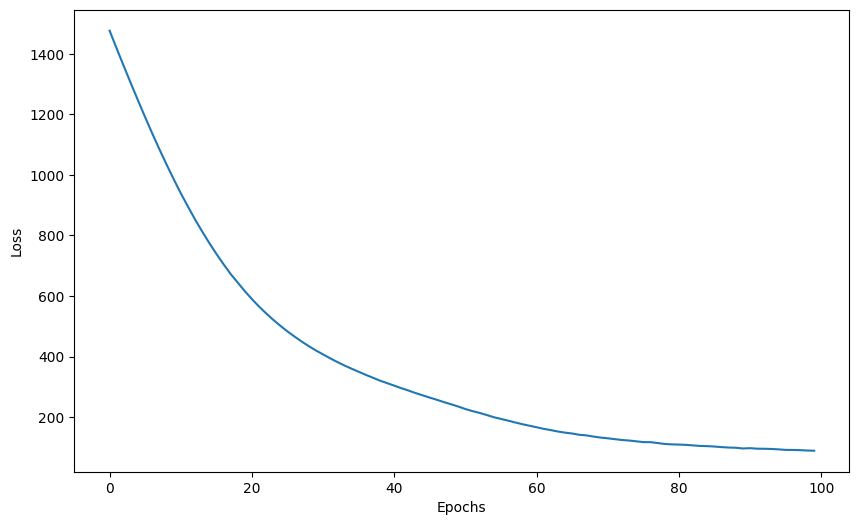

In [10]:
import matplotlib.pyplot as plt

indices = range(0,100,1)
plt.figure(figsize=(10,6))
plt.plot(indices, mean_losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [11]:
# Save results
model_backbone_weights = model.student_model.backbone
print(model_backbone_weights)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [12]:
 ! mkdir ./output/BYOL

In [13]:
torch.save({ 'model_state_dict': model_backbone_weights.state_dict() }, f'{save_path}/efficientnet_b0_backbone_weights.ckpt')

## Fine-tuning

In [14]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch

# Path to the dataset
dataset_path = './datasets/COVIDGR_1.0'
positive_path = os.path.join(dataset_path, 'P')
negative_path = os.path.join(dataset_path, 'N')

# Data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.3, 0.9), ratio=(3/4, 4/3)),
    transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
            p=0.8
        ),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=25, sigma=(0.1, 2.0))], p=0.5),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

In [15]:
# Step 4: Map labels
dataset.class_to_idx = {'N': 0, 'P': 1}
dataset

Dataset ImageFolder
    Number of datapoints: 852
    Root location: ./datasets/COVIDGR_1.0
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.3, 0.9), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomApply(
               p=0.8
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.8, 1.2], hue=[-0.1, 0.1])
           )
               RandomGrayscale(p=0.2)
               RandomApply(
               p=0.5
               GaussianBlur(kernel_size=(25, 25), sigma=(0.1, 2.0))
           )
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [16]:
# Splitting the dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
batch_size = 256
print(train_size, batch_size)

# Split off the test set
train_val_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader for the test set (held out)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

766 256


In [17]:
checkpoint_path = "./output/BYOL/efficientnet_b0_backbone_weights.ckpt"
best_params = {"learning_rate": 0.01, "weight_decay": 0.001}

In [18]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim

def get_model():
    # Load the EfficientNet model
    model = efficientnet_b0()
    
    # Modify the final classification head for your dataset
    embed_dim = model.classifier[1].in_features
    model.classifier[1] = nn.Identity()
    
    # Load the pre-trained weights
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
    # Remove unnecessary keys (e.g., DINO projection head weights)
    state_dict = checkpoint["model_state_dict"]  # Adjust the key if needed
    # remove `module.` prefix
    # state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    # state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    
    # Load the weights into the model
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(checkpoint_path, msg))

    # Freeze model params
    for param in model.features.parameters():
        param.requires_grad = False
    return model, embed_dim

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import time
from sklearn.model_selection import KFold

print (np.__version__)


def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1


def train_model(model, classifier, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    classifier = classifier.to(device)
    train_losses, val_losses = [], []
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = classifier(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust learning rate

        # Validation phase
        classifier.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                outputs = classifier(outputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Metrics
        accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        if f1 > best_val_f1:
            best_val_f1 = f1

        print(f"[{device}] Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, F1 Score: {f1:.4f}")

    return best_val_f1

# Evaluate model on the test set
def evaluate_model(model, classifier, test_loader):
    classifier.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    classifier = classifier.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = classifier(outputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    return accuracy, precision, recall, f1

def grid_search(train_loader, val_loader, learning_rates, weight_decays, num_epochs):
    best_model = None
    best_f1 = 0
    best_params = {}
    for lr in learning_rates:
        for wd in weight_decays:
            model = get_model()
            optimizer = optim.SGD(model.classifier[1].parameters(), lr=lr, weight_decay=wd, momentum=0.9)
            scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, (epoch + 1) / 10))
            criterion = nn.CrossEntropyLoss()
            print(f"\nTraining with lr={lr}, weight_decay={wd}")
            f1_score = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = model
                best_params = {"learning_rate": lr, "weight_decay": wd}
    print(f"\nBest Model F1: {best_f1} with params {best_params}")
    return best_model, best_params

# Step 9: 5-Fold Cross-Validation
def cross_validation(best_params, dataset, test_loader, num_epochs=50, folds=5):
    fold_metrics = []
    kfold = KFold(n_splits=folds, shuffle=True, random_state=100)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nStarting fold {fold + 1}/{folds}")

        # Split dataset indices for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders for this fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model, embed_dim = get_model()
        linear_classifier = nn.Linear(embed_dim, 2) # 2 is the number of features
        optimizer = optim.SGD(linear_classifier.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'], momentum=0.9)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, (epoch + 1) / 10))
        criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        _ = train_model(model, linear_classifier, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
        end_time = time.time()

        # Evaluate on test set
        accuracy, precision, recall, f1 = evaluate_model(model, linear_classifier, test_loader)
        fold_metrics.append((accuracy, precision, recall, f1, end_time - start_time))

    return np.array(fold_metrics)

1.26.4


In [20]:
# Run the 5-fold cross-validation
metrics = cross_validation(best_params, train_val_dataset, test_loader, num_epochs=50, folds=5)

# Calculate average and standard deviation of metrics across folds
avg_metrics = metrics.mean(axis=0)
std_metrics = metrics.std(axis=0)

print(f"\nAverage metrics over 5 folds in test set:\n"
      f"Accuracy: {avg_metrics[0]:.4f} ± {std_metrics[0]:.4f}\n"
      f"Precision: {avg_metrics[1]:.4f} ± {std_metrics[1]:.4f}\n"
      f"Recall: {avg_metrics[2]:.4f} ± {std_metrics[2]:.4f}\n"
      f"F1 Score: {avg_metrics[3]:.4f} ± {std_metrics[3]:.4f}\n"
      f"Training Time per Fold: {avg_metrics[4]:.2f} ± {std_metrics[4]:.2f} seconds")


Starting fold 1/5
Pretrained weights found at ./output/BYOL/efficientnet_b0_backbone_weights.ckpt and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['conv1.weight'])
[cuda] Epoch 1/50, Train Loss: 0.7262, Val Loss: 0.7080, F1 Score: 0.4595
[cuda] Epoch 2/50, Train Loss: 0.7140, Val Loss: 0.7638, F1 Score: 0.5059
[cuda] Epoch 3/50, Train Loss: 0.7276, Val Loss: 0.6876, F1 Score: 0.5644
[cuda] Epoch 4/50, Train Loss: 0.6957, Val Loss: 0.7400, F1 Score: 0.4032
[cuda] Epoch 5/50, Train Loss: 0.7074, Val Loss: 0.6781, F1 Score: 0.5385
[cuda] Epoch 6/50, Train Loss: 0.6792, Val Loss: 0.6855, F1 Score: 0.4960
[cuda] Epoch 7/50, Train Loss: 0.7029, Val Loss: 0.7104, F1 Score: 0.6044
[cuda] Epoch 8/50, Train Loss: 0.7457, Val Loss: 0.6686, F1 Score: 0.5649
[cuda] Epoch 9/50, Train Loss: 0.7456, Val Loss: 0.6432, F1 Score: 0.6556
[cuda] Epoch 10/50, Train Loss: 0.7079, Val Loss: 0.6871, F1 Score: 0.4553
[cuda] Epoch 11/50, Train Loss: 0.7004, Val Loss: 0.6805, F1 Score: 0.

In [21]:
metrics

array([[7.09302326e-01, 8.18181818e-01, 5.86956522e-01, 6.83544304e-01,
        1.86407737e+03],
       [5.34883721e-01, 6.25000000e-01, 3.26086957e-01, 4.28571429e-01,
        1.89779209e+03],
       [6.62790698e-01, 6.88888889e-01, 6.73913043e-01, 6.81318681e-01,
        1.87697351e+03],
       [6.04651163e-01, 6.03448276e-01, 7.60869565e-01, 6.73076923e-01,
        1.89954106e+03],
       [6.86046512e-01, 8.51851852e-01, 5.00000000e-01, 6.30136986e-01,
        1.89561574e+03]])

In [22]:
import pandas as pd

results = pd.DataFrame(metrics, columns=['accuracy', 'precision', 'recall', 'f1', 'training time'])
results.head()

,accuracy,precision,recall,f1,training time
0,0.709302,0.818182,0.586957,0.683544,1864.077372
1,0.534884,0.625000,0.326087,0.428571,1897.792086
2,0.662791,0.688889,0.673913,0.681319,1876.973509
3,0.604651,0.603448,0.760870,0.673077,1899.541061
4,0.686047,0.851852,0.500000,0.630137,1895.615739


In [23]:
results.to_csv('./results/byol_fine_tuned.csv')